In [42]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import time 

import torch
import mrmr
from torch import nn
from torch.utils.data import Dataset, DataLoader

In [43]:
# Constants
DATA_PATH = './data/'
DATASET_PATH = DATA_PATH + 'smartphone+based+recognition+of+human+activities+and+postural+transitions/'
MODELS_PATH = DATA_PATH + 'models/'

In [44]:
# Loading functions
def load_data_frame(txt):
    return pd.read_csv(DATASET_PATH + txt + '.txt', header=None, sep='\s+')


In [45]:
# Loading data
train_set = load_data_frame('Train/X_train')
test_set = load_data_frame('Test/X_test')

features = []
with open(DATASET_PATH + 'features.txt') as f:
    for line in f:
        feat = line.strip()
        features.append(feat)

train_set.columns = features
test_set.columns = features

train_set['subjectId'] = load_data_frame('Train/subject_id_train')
train_set['activity'] = load_data_frame('Train/y_train')

test_set['subjectId'] = load_data_frame('Test/subject_id_test')
test_set['activity'] = load_data_frame('Test/y_test')

activity_labels = load_data_frame('activity_labels')
activity_labels.columns = ['id', 'activity']

features = train_set.columns.tolist()

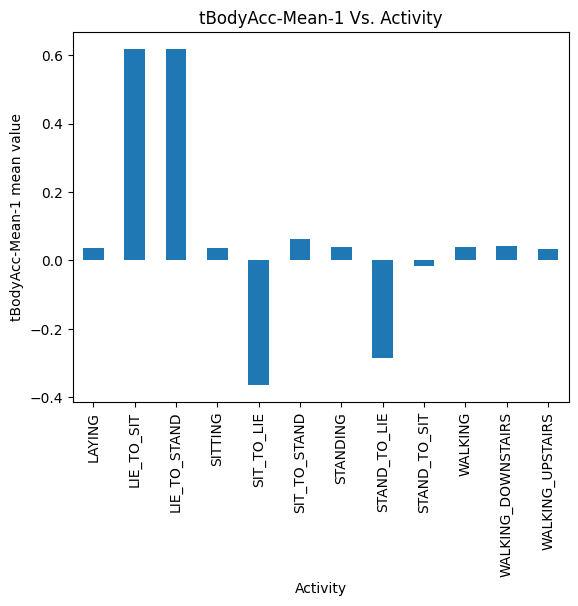

In [46]:
# Graphing features
complete_set_train = train_set.copy()
for x in activity_labels['id']:
    complete_set_train['activity'] = complete_set_train['activity'].replace(x, activity_labels['activity'][x - 1])

selected_features_graph = ['tBodyAcc-Mean-1']

for selected_feature in selected_features_graph:
    if selected_feature != '':
        train_subset = complete_set_train[[selected_feature, 'activity']]
        grouped_train_by_feature = train_subset.groupby('activity').mean()

        grouped_train_by_feature.plot(kind='bar', legend=False)
        plt.title(selected_feature + ' Vs. Activity')
        plt.xlabel('Activity')
        plt.ylabel(selected_feature + ' mean value')
        plt.show()


In [47]:
# Creating model
device = None

if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

num_features = 30

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.05),
            nn.Linear(128, 32),
            nn.SiLU(),
            nn.Linear(32, 8),
            nn.Softmax()  # or nn.Softmax(dim=1) for multi-class classification
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [48]:
# Training and testing function
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        y = y.squeeze()
        X, y = X.to(device), y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            y = y.squeeze()
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    return(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [49]:
# Dataset preparation
class HAPTDataset(Dataset):
    def __init__(self, dataset, features, label):
        self.data = torch.tensor(dataset[features].values, dtype=torch.float32)
        self.labels = torch.tensor(dataset[label].values, dtype=torch.float32)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]
    
mrmr_selected_features = mrmr.mrmr_classif(train_set[features[:-1]], train_set[features[-1]], num_features)
    
train_dataset = HAPTDataset(train_set, mrmr_selected_features, 'activity')
test_dataset = HAPTDataset(test_set, mrmr_selected_features, 'activity')

train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=True)

100%|██████████| 30/30 [00:05<00:00,  5.09it/s]


In [50]:
epochs = 5
perf_timer = time.perf_counter()
perf_acc = ""

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_function, optimizer)
    perf_acc = test(test_dataloader, model, loss_function)
    
print(perf_acc)
perf_timer = time.perf_counter() - perf_timer
print("Done!")

Epoch 1
-------------------------------
loss: 2.076976  [    8/ 7767]
loss: 1.770326  [  808/ 7767]
loss: 1.540131  [ 1608/ 7767]
loss: 1.487790  [ 2408/ 7767]
loss: 1.597384  [ 3208/ 7767]
loss: 1.782714  [ 4008/ 7767]
loss: 1.374419  [ 4808/ 7767]
loss: 1.455832  [ 5608/ 7767]
loss: 1.348761  [ 6408/ 7767]
loss: 1.591755  [ 7208/ 7767]
Epoch 2
-------------------------------
loss: 1.447364  [    8/ 7767]
loss: 1.436237  [  808/ 7767]
loss: 1.371282  [ 1608/ 7767]
loss: 1.415595  [ 2408/ 7767]
loss: 1.452583  [ 3208/ 7767]
loss: 1.331313  [ 4008/ 7767]
loss: 1.640200  [ 4808/ 7767]
loss: 1.738051  [ 5608/ 7767]
loss: 1.382554  [ 6408/ 7767]
loss: 1.183193  [ 7208/ 7767]
Epoch 3
-------------------------------
loss: 1.375167  [    8/ 7767]
loss: 1.577036  [  808/ 7767]
loss: 1.464426  [ 1608/ 7767]
loss: 1.385119  [ 2408/ 7767]
loss: 1.399073  [ 3208/ 7767]
loss: 1.418772  [ 4008/ 7767]
loss: 1.596740  [ 4808/ 7767]
loss: 1.457132  [ 5608/ 7767]
loss: 1.398166  [ 6408/ 7767]
loss: 1.69

In [51]:
if True:
    torch.save(model.state_dict(), DATA_PATH + "models/nn_1.pth")
    print("Saved PyTorch Model State to model.pth")

    with open(DATA_PATH + "models/nn_1.txt", "w") as f:
        f.write("Epochs: {}\n".format(epochs))
        f.write("Feature Selection: {}\n".format("MRMR"))
        f.write("Feature Set: Top {}\n".format(num_features))
        f.write("Model: {}\n".format(str(model)))
        f.write("Loss Function: {}\n".format("Cross Entropy Loss"))
        f.write("Optimizer: {}\n\n\n\n".format(str(optimizer)))
        f.write("Results: {}\n".format(perf_acc))
        f.write("Timer: {}s\n".format(round(perf_timer, 2)))

Saved PyTorch Model State to model.pth
